# 03. 시계열 기반 반도체 기술 트렌드 예측
## Tech Trend Forecasting using Linear Regression

이 노트북은 `data/processed/tech_trends_quarterly.csv`를 활용하여
HBM, DDR, NAND 등 주요 기술 키워드의 **분기별 언급량 시계열**을 분석하고,
간단한 선형 회귀 모델을 이용해 **향후 분기별 트렌드 예측 곡선**을 생성합니다.

생성되는 그래프는 연구 보고서의 도식(예: *그림 3. 기술별 트렌드 예측 곡선*)에 해당합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os

sns.set(style="whitegrid")
font_name = "NanumGothic"
plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False

DATA_PATH = "../data/processed/tech_trends_quarterly.csv"
print(f"Loading: {DATA_PATH} (font={font_name})")
trends = pd.read_csv(DATA_PATH)
print(trends.head())


Loading: ../data/processed/tech_trends_quarterly.csv (font=NanumGothic)
     date  company  HBM  DDR  NAND  DRAM  EUV  GAA  파운드리  CIS  SSD  AP  패키징
0  2016Q1  SKHynix    0    1     4    18    0    0     0    2    1   2    0
1  2016Q1  Samsung   18    7     0     0    0    0     4    0   31   5    0
2  2016Q2  SKHynix    0   12    70     6    0    0     0    4   15   1    0
3  2016Q2  Samsung    0   27     0     0    1    0     0    0   22   4    2
4  2016Q3  SKHynix    0   24    15     7    3    0     0    1    6   7    0


In [2]:
# 분기(date)를 시계열 인덱스로 변환
trends['date'] = trends['date'].astype(str)
# 정렬 보장
trends = trends.sort_values(['company', 'date'])

tech_cols = [c for c in trends.columns if c not in ['date', 'company']]
print("기술 컬럼:", tech_cols)


기술 컬럼: ['HBM', 'DDR', 'NAND', 'DRAM', 'EUV', 'GAA', '파운드리', 'CIS', 'SSD', 'AP', '패키징']


In [3]:
def forecast_tech(trends_df, company, tech, horizon=8):
    """단순 선형 회귀를 사용해 향후 horizon 개 분기 예측"""
    df = trends_df[trends_df['company'] == company].copy()
    if tech not in df.columns:
        raise ValueError(f"컬럼 {tech} 이(가) 데이터에 없습니다.")

    # 시간 인덱스 t = 0..T-1
    df = df.reset_index(drop=True)
    df['t'] = np.arange(len(df))

    X = df[['t']].values
    y = df[tech].values

    model = LinearRegression()
    model.fit(X, y)

    # 미래 t 값 생성
    last_t = df['t'].iloc[-1]
    future_t = np.arange(last_t + 1, last_t + 1 + horizon)
    future_X = future_t.reshape(-1, 1)
    future_pred = model.predict(future_X)

    # 결과 DataFrame 구성
    hist_df = df[['date', tech]].copy()
    hist_df['type'] = 'actual'

    # 미래 date 라벨은 단순히 t 인덱스로 표기 (혹은 별도 매핑 가능)
    future_df = pd.DataFrame({
        'date': [f"t+{i}" for i in range(1, horizon + 1)],
        tech: future_pred,
        'type': 'forecast'
    })

    return hist_df, future_df, model


In [4]:
def plot_forecast(trends_df, company, tech, horizon=8):
    hist_df, future_df, model = forecast_tech(trends_df, company, tech, horizon=horizon)
    combined = pd.concat([hist_df, future_df], ignore_index=True)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=combined, x='date', y=tech, hue='type', marker='o')
    plt.title(f"{company} - {tech} 분기별 언급량 및 예측")
    plt.xticks(rotation=45)
    plt.ylabel("Mention Frequency")
    plt.tight_layout()
    plt.show()

    coef = float(model.coef_[0])
    print(f"선형 회귀 계수 (추세 기울기): {coef:.3f}")
    return coef


SKHynix - HBM 예측


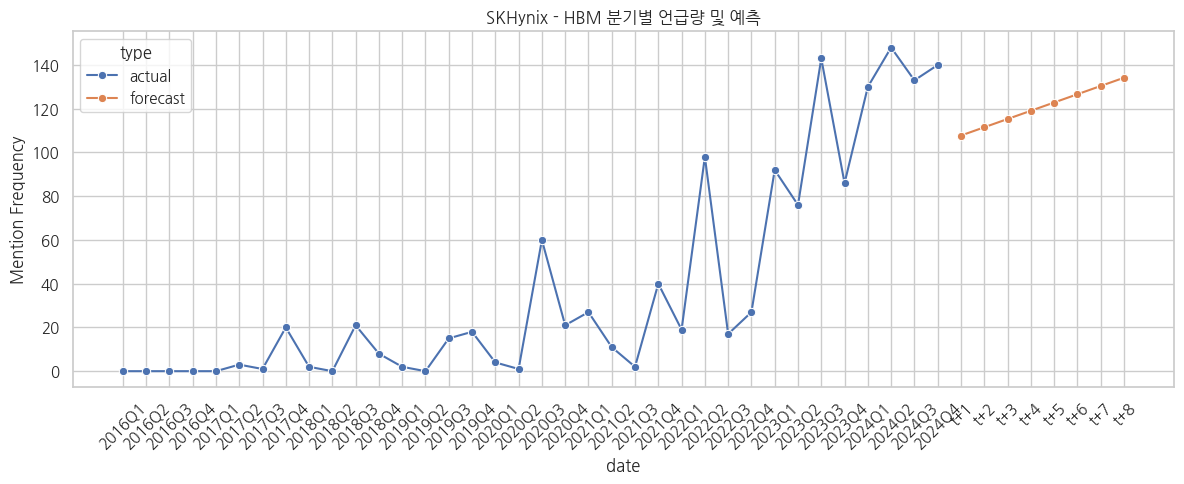

선형 회귀 계수 (추세 기울기): 3.775
SKHynix - DDR 예측


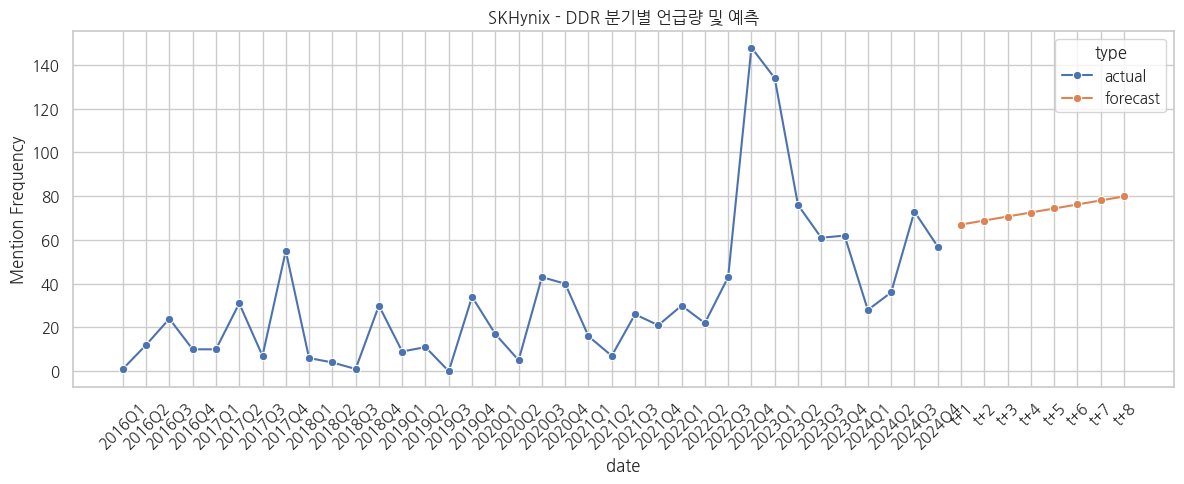

선형 회귀 계수 (추세 기울기): 1.837
SKHynix - NAND 예측


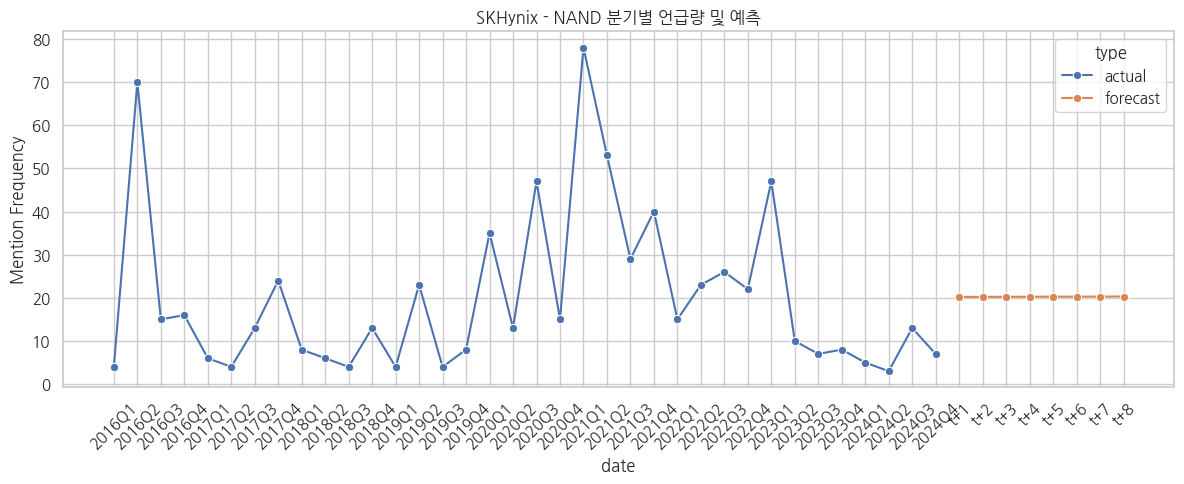

선형 회귀 계수 (추세 기울기): 0.014
Samsung - HBM 예측


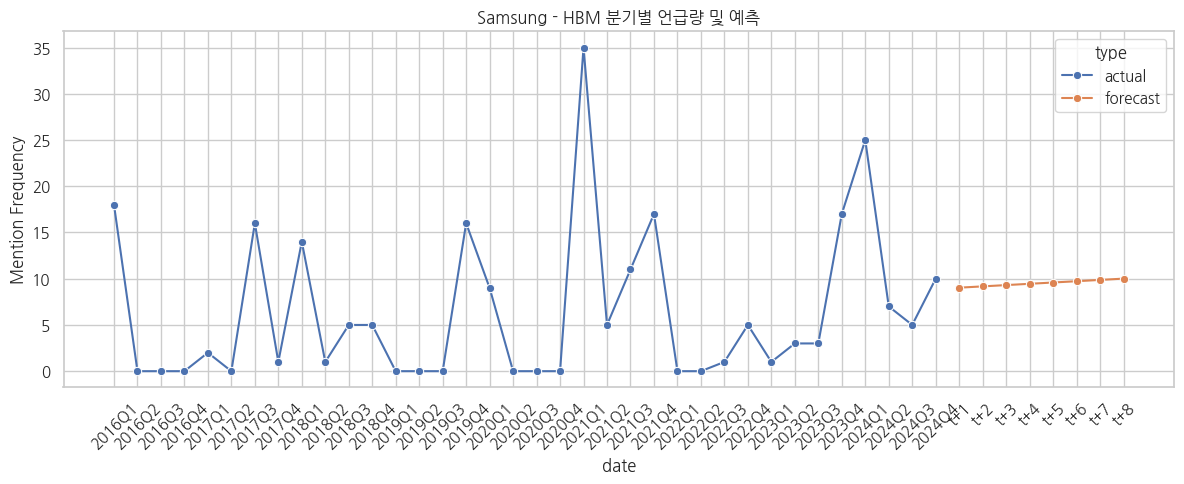

선형 회귀 계수 (추세 기울기): 0.140
Samsung - DDR 예측


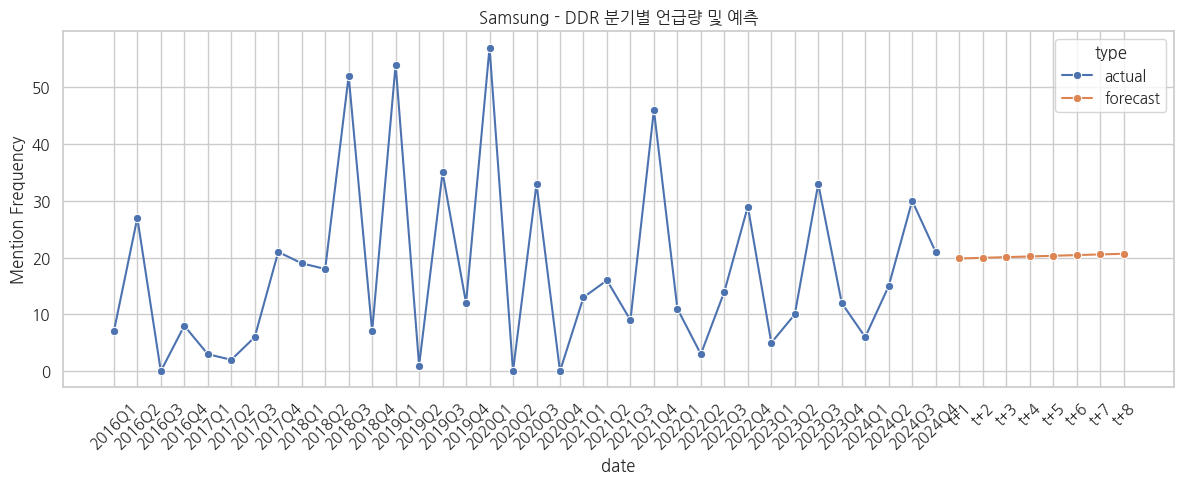

선형 회귀 계수 (추세 기울기): 0.119
Samsung - NAND 예측


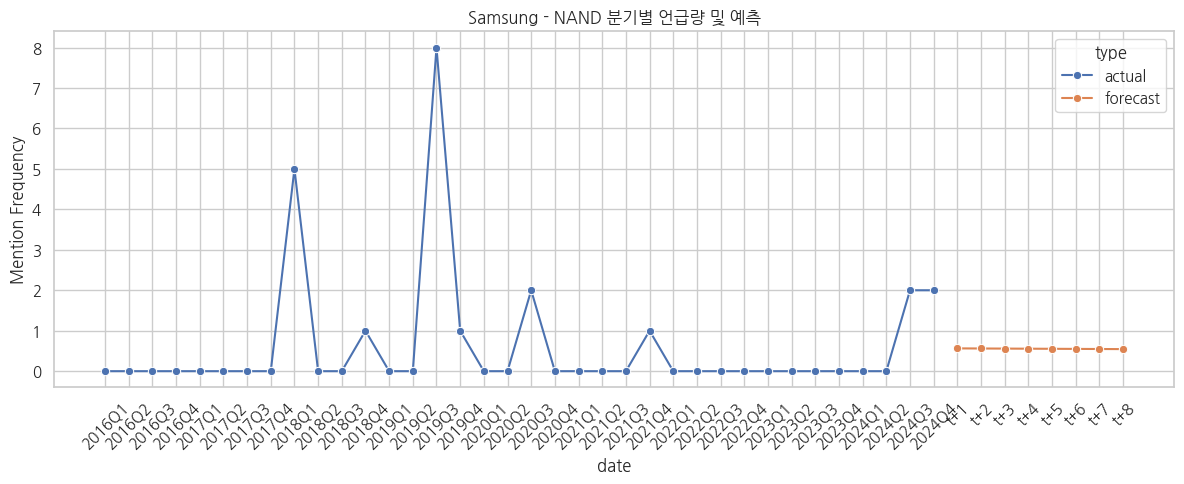

선형 회귀 계수 (추세 기울기): -0.003


,company,tech,trend_coef
0,SKHynix,HBM,3.774903
1,SKHynix,DDR,1.837323
2,SKHynix,NAND,0.014157
3,Samsung,HBM,0.139768
4,Samsung,DDR,0.119305
5,Samsung,NAND,-0.002574


In [5]:
# 예시: HBM, DDR, NAND에 대해 삼성/하이닉스 각각 예측 수행
target_techs = [t for t in ['HBM', 'DDR', 'NAND'] if t in tech_cols]
companies = trends['company'].unique()

results = []
for company in companies:
    for tech in target_techs:
        print("="*60)
        print(f"{company} - {tech} 예측")
        coef = plot_forecast(trends, company, tech, horizon=8)
        results.append({
            'company': company,
            'tech': tech,
            'trend_coef': coef
        })

trend_summary = pd.DataFrame(results)
trend_summary
